This is my practice data science challenge answers from *A Collection of Data Science Take-Home Challenges*

**Goal: Predict conversion rate, and come up with recommendations on how to improve the conversion rate for a website**
    

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, RidgeClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score, make_scorer, precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest

In [2]:
conversion = pd.read_csv("conversion_data.csv")

In [3]:
#Let's look at some of this data:
conversion.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [4]:
conversion.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316200 entries, 0 to 316199
Data columns (total 6 columns):
country                316200 non-null object
age                    316200 non-null int64
new_user               316200 non-null int64
source                 316200 non-null object
total_pages_visited    316200 non-null int64
converted              316200 non-null int64
dtypes: int64(4), object(2)
memory usage: 14.5+ MB


In [5]:
conversion.describe()
#more new users than not...total pages visited is about 5...converted is around 3.22%
#Also, we need to look at what is up with the max age of 123!

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


In [6]:
conversion.country.value_counts()
#most people from the US

US         178092
China       76602
UK          48450
Germany     13056
Name: country, dtype: int64

In [7]:
#Let's look more at the conversion rate:
conversion[conversion.converted==0].source.value_counts()

Seo       149940
Ads        85680
Direct     70380
Name: source, dtype: int64

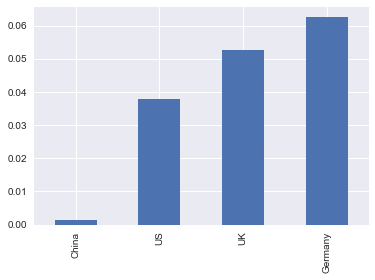

In [8]:
(conversion[conversion.converted==1]["country"].value_counts() / 
 conversion["country"].value_counts()).sort_values().plot(kind="bar")

China's conversion rate is much lower than the other countries

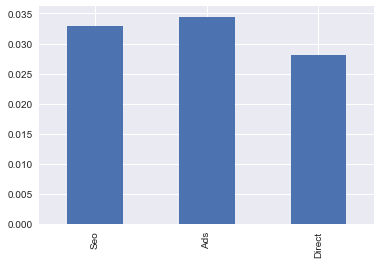

In [9]:
(conversion[conversion.converted==1].source.value_counts()
/conversion.source.value_counts()).plot("bar")


Showing up to the site via SEO and Ads have roughly the same conversion rate, and a bit lower for direct

In [10]:
conversion.age.sort_values().value_counts(sort=False)
#couple of crazy ages in there

17      7597
18      8466
19      9349
20     10156
21     10966
22     11701
23     12336
24     12960
25     13460
26     13931
27     14084
28     14341
29     14158
30     14346
31     13692
32     13507
33     12631
34     12108
35     11471
36     10779
37      9761
38      8970
39      8202
40      7148
41      6401
42      5588
43      4904
44      4224
45      3634
46      2994
47      2504
48      2121
49      1629
50      1356
51      1093
52       935
53       627
54       520
55       394
56       286
57       247
58       165
59       127
60        94
61        71
62        59
63        35
64        27
65        15
66         9
67         5
68         5
69         3
70         2
72         1
73         1
77         1
79         1
111        1
123        1
Name: age, dtype: int64

In [11]:
#Those ages were probably mistypes, and since there is only two, we can safely get rid of them
conversion = conversion[conversion.age < 80]

Are there differences in conversion based on age?

In [12]:
conversion[conversion.converted==1].age.mean()

26.52902529907825

In [13]:
conversion[conversion.converted==0].age.mean()

30.703960784313725

Those who are younger tend to convert more.

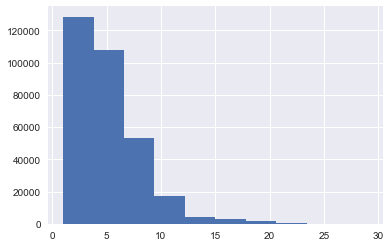

In [14]:
#Let's take a look at page views as well
conversion['total_pages_visited'].hist()

Most people view 5 or less pages. Is there a difference in pages viewed between those who converted and those who didn't?

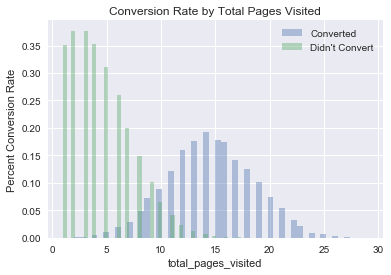

In [15]:
sns.distplot(conversion[conversion.converted==1]['total_pages_visited'], kde=False, norm_hist=True, label="Converted")
sns.distplot(conversion[conversion.converted==0]['total_pages_visited'], kde=False, norm_hist=True, label= "Didn't Convert")
plt.legend()
plt.title("Conversion Rate by Total Pages Visited")
plt.ylabel("Percent Conversion Rate")

Do new users convert more?

In [ ]:
print(converion[conversion.new_user == 1 and conversion.converted==1] / len(conversion))
print(converion[conversion.new_user == 0 and conversion.converted==0] / len(conversion))


**Modelling**

Let's do some modelling to see how well we can predict conversion rate. I will use two different algorithms: Logistic Regression and Random Forests classifier. Since we are predicting 'yes' or 'no' for conversion we need to use a classifier. I picked logistic regression since it is simple, quick, and we can get somewhat of  an understanding of what predicts conversion by looking at the coefficients. I picked a random forest classifier because it does not require much tuning out of the box, and tends to be more accurate than logistic regression, especially if there are non-linear relationships in the data.

If I were to have more time. I would try some grid serach especially on logistic regression to try different types of regularization, etc. I would also try more complex models that require more tuning like Gradient Boosted Trees.

In [18]:
#We need to first make dummy variables for the categorical values:
country_dummies = pd.get_dummies(conversion.country)
source_dummies = pd.get_dummies(conversion.source)
conversion_final = pd.concat([conversion[["age", "new_user", "total_pages_visited", "converted"]]\
                              , country_dummies, source_dummies], axis=1)


In [19]:
#Let's also scale the values for age and total_pages_visited to help with the intrepetability of Logistic Regression
MMS = MinMaxScaler()

In [20]:
conversion_final["age"] = MMS.fit_transform(conversion_final["age"])
conversion_final["total_pages_visited"] = MMS.fit_transform(conversion_final["total_pages_visited"])


//anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)
//anaconda/lib/python3.5/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
//anaconda/lib/python3.5/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
//anaconda/lib/python3.5/site-packages/sklearn/preproces

In [21]:
conversion_final.head()

,age,new_user,total_pages_visited,converted,China,Germany,UK,US,Ads,Direct,Seo
0,0.129032,1,0.000000,0,0,0,1,0,1,0,0
1,0.096774,1,0.142857,0,0,0,0,1,0,0,1
2,0.177419,1,0.107143,0,0,0,0,1,0,0,1
3,0.354839,1,0.142857,0,1,0,0,0,0,0,1
4,0.209677,1,0.178571,0,0,0,0,1,0,0,1


Let's try Logistic Regression with balanced and unbalanced classes--remember that there is significantly more not converted than converted

In [22]:
LR = LogisticRegression()
LR_bal = LogisticRegression(class_weight="balanced")

In [23]:
#splitting data into train and test splits
X_train, X_test, y_train, y_test = train_test_split(conversion_final.loc[:, conversion_final.columns != "converted"]
, conversion.converted, test_size=0.20, random_state=42)

In [24]:
LR.fit(X_train, y_train)
LR_bal.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [25]:
print(LR.score(X_train, y_train), LR_bal.score(X_train,y_train))

0.986033254532 0.941867819954


In [26]:
print(LR.score(X_test, y_test), LR_bal.score(X_test, y_test))



0.986543327008 0.942979127135


We got a pretty good accuracy score and there doesn't appear to be any overfitting which is good. Let's take a look
at the classification report:

In [27]:
print("Unbalanced:")
print(classification_report(LR.predict(X_test), y_test))
print("Balanced:")
print(classification_report(LR_bal.predict(X_test), y_test))

Unbalanced:
             precision    recall  f1-score   support

          0       1.00      0.99      0.99     61626
          1       0.69      0.87      0.77      1614

avg / total       0.99      0.99      0.99     63240

Balanced:
             precision    recall  f1-score   support

          0       0.94      1.00      0.97     57863
          1       0.94      0.35      0.51      5377

avg / total       0.94      0.94      0.93     63240



Overall, class_weighted=False seems to produce better results. Logistic Regression does a great job of predicting those who did not convert and fairly good job predicting those who did. For the converted class we do only get a .69 for precision, meaning 31% of those who did convert are being labeled as didn't convert, but overall the model is doing a fairly good job.

In [34]:
#Let's see what the important coefficients are:
coef_columns = [x for x in conversion_final.columns if x != "converted"]


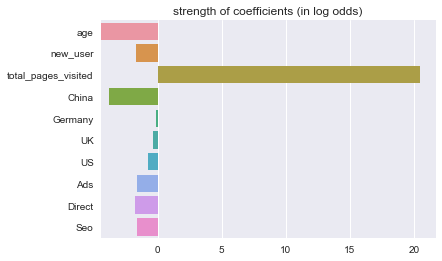

In [106]:
sns.barplot(y=coef_columns, x = LR.coef_.ravel(), orient="h")
plt.title("Weight of Coefficients")

Though coefficients for logistic regresion are not directly and completely interpretable. It does appear that total pages visited does lead to more people converting. Let's run a feature importances algorithm too.

In [109]:
SKB = SelectKBest()

In [110]:
SKB.fit(X_train, y_train)

SelectKBest(k=10, score_func=<function f_classif at 0x10ef7af28>)

In [115]:
tuples = []
for x,y in zip(SKB.scores_, coef_columns):
    tuples.append([x,y])
tuples = sorted(tuples, key= lambda x: abs(x[0]), reverse=True)

In [116]:
tuples

[[98220.90723838126, 'total_pages_visited'],
 [6137.7245946643288, 'new_user'],
 [2494.0097641900879, 'China'],
 [2031.4638653542695, 'age'],
 [635.87096552733783, 'UK'],
 [309.45427818396979, 'Germany'],
 [307.96512978746011, 'US'],
 [33.02529761358511, 'Direct'],
 [12.296998481356288, 'Ads'],
 [2.821246693306779, 'Seo']]

Again it looks like total pages visited is important as well as whether or not the person is a new user from China, and his or her age. How they got to the site does not seem to have that much of importance.

Let's move on to a random forest classifier:

In [28]:
RF = RandomForestClassifier( n_estimators=300)
RF_bal = RandomForestClassifier( n_estimators=300, class_weight="balanced")

In [29]:
RF.fit(X_train, y_train)
RF_bal.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [30]:
print(RF.score(X_train, y_train), RF_bal.score(X_train, y_train))

0.988211481748 0.963614513081


In [31]:
print(RF.score(X_test, y_test), RF_bal.score(X_test, y_test))


0.984993674889 0.958807716635


In [32]:
print("Unbalanced:")
print(classification_report(RF.predict(X_test), y_test))
print("Balanced:")
print(classification_report(RF_bal.predict(X_test), y_test))

Unbalanced:
             precision    recall  f1-score   support

          0       1.00      0.99      0.99     61548
          1       0.68      0.82      0.75      1692

avg / total       0.99      0.98      0.99     63240

Balanced:
             precision    recall  f1-score   support

          0       0.96      0.99      0.98     59232
          1       0.84      0.43      0.57      4008

avg / total       0.96      0.96      0.95     63240



The random forest classifier did slightly worse than the logistic regression one, but it was helpful to run this classifier because we can see which features were most important to split on:

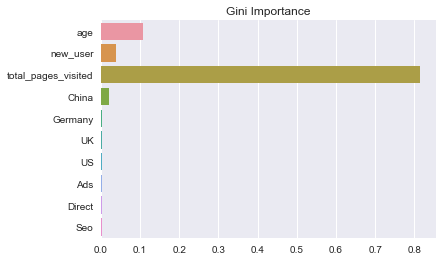

In [36]:
sns.barplot(y=coef_columns, x = RF.feature_importances_.ravel(), orient="h")
plt.title("Gini Importance")

This matches our features importances from earlier, again the most important features seem to be age, whether or not someone is a new user, total pages visited, and if they are from China or not.

**Final Analysis:**
1. Though Germany has the highest conversion rate, not a lot of visitors are coming from Germany. It has a fourth of the visitors of the UK even though Germany is bigger than the UK. We need to find a way to incentive more Germans to buy. Maybe with free shipping and/or making sure the German translation of the website is correct.
2. China is a huge red flag. Their conversion rate is close to zero and way lower than that of the other countries. They have the second most amount of people going to the website, and have a huge population with a middle class getting larger every day. We need to understand why Chinese people are not converting enough. Maybe the translation of the site is faulty, or shippping is expensive to China. This needs to be explored more.
3. There is a tendency for younger people to convert more than older people. It may be beneficial to target those people based on email or other types of advertising.
4. Total pages visited seems to be highly associated with converting or not. It is hard to change this metric directly, but we should work on getting people to stay on the site longer. Maybe double check there is no speed issues or other issues with getting around the site. 
5. Previous users tend to convert more than new users, which again is not suprising, so maybe we can have an adertising campaign, like a coupon code or something, to get previous users back to the site.